In [1]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # Code specific to Google Colab
    print("Running in Google Colab")
    
    # Additional setup commands for Colab
    !pip install neuralforecast
    !pip install gymnasium
else:
    # Code for other environments (e.g., VS Code)
    print("Running in another environment (e.g., VS Code)")

Running in another environment (e.g., VS Code)


In [2]:
if IN_COLAB:
    !wget --recursive --no-parent --cut-dirs=4 -P /content https://raw.githubusercontent.com//CodeBeckZero/MADDQN/main/environments/stockenv.py
    !wget --recursive --no-parent --cut-dirs=4 -P /content https://raw.githubusercontent.com//CodeBeckZero/MADDQN/main/utilities/cleandata.py
    !wget --recursive --no-parent --cut-dirs=4 -P /content https://raw.githubusercontent.com//CodeBeckZero/MADDQN/main/utilities/data.py



import sys
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utilities.data import RunningWindowDataset, DateTimeSlidingWindowDataset
from utilities.cleandata import YAHOO_csv_input
from environments.stockenv import ContinuousOHLCVEnv
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from neuralforecast.core import NeuralForecast
from neuralforecast.models import TimesNet
from neuralforecast.losses.numpy import mae, mse
from datetime import datetime

def set_seed(seed):
    """Set seed for reproducibility."""
    # Python random module
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)

    # If you are using CUDA
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
        # Additional settings to force determinism in your operations:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [3]:
pwd = "C:/programming/MADDQN"
sys.path.append(pwd)

# Input Data Location, File Name, Stock name for labels
input_url = 'https://raw.githubusercontent.com/CodeBeckZero/MADDQN/main/input_data'

stock_inputs ={'DJI':'^DJI_daily.csv',
               'NDAQ': '^IXIC_daily.csv',
               'SP500': '^SPX_daily.csv',
               'AAPL': 'AAPL_daily.csv',
               'AMZN': 'AMZN_daily.csv',
               'GOOGL': 'GOOGL_daily.csv',
               'MSFT': 'MSFT_daily.csv',
               'SINE': 'sine_wave_daily.csv',
               'FORD': 'F_daily.csv',
               'JNJ': 'JNJ_daily.csv',
               'NEE': 'NEE_daily.csv',
               'PFE': 'PFE_daily.csv',
               'TSLA': 'TSLA_daily.csv'}


# Exodenus Variable Input
exo_var_datasets = ['DJI','NDAQ','SP500']
exo_vars = ['close']

exo_vars_df = pd.DataFrame()
for name, file in stock_inputs.items():
    if name in exo_var_datasets:
        df_ohlcv = YAHOO_csv_input(file, input_url)
        if exo_var_datasets.index(name) == 0:
            exo_vars_df['date'] = df_ohlcv['date']     
            for column in exo_vars:
                exo_vars_df[f'{name}_{column}'] = df_ohlcv[column]
        else:
            df_merge = df_ohlcv[['date'] + exo_vars]  # Selecting 'date' and desired columns
            exo_vars_df = pd.merge(exo_vars_df, df_merge, on='date', how='inner')
            for column in exo_vars:
                exo_vars_df.rename(columns={column:f'{name}_{column}'},inplace=True)

exo_vars_df.rename(columns={'date':'ds'},inplace=True)
            
# Training Inputs
trn_keys = ['AAPL']
training_range = ('2007-01-03','2007-12-29')
trn_dt_range = [datetime.strptime(dt_str, "%Y-%m-%d") for dt_str in training_range]

# Validation Inputs
val_keys = trn_keys
validation_range = ('2021-01-04','2021-12-31')
val_dt_range = [datetime.strptime(dt_str, "%Y-%m-%d") for dt_str in validation_range]

# Testing Inputs
tst_keys = trn_keys
testing_range = ('2008-01-02','2008-02-29')
tst_dt_range = [datetime.strptime(dt_str, "%Y-%m-%d") for dt_str in testing_range]

window_size = 250
columns = ['open','high','low','close']

env = {}

for name, file in stock_inputs.items():
    if name in set(trn_keys + val_keys + tst_keys):
        df_ohlcv = YAHOO_csv_input(file, input_url)
        rw_datatime = DateTimeSlidingWindowDataset(df_ohlcv['date'],window_size)
        rw_ohlc_data = RunningWindowDataset(df_ohlcv[columns],window_size)
        rw_closing_price = RunningWindowDataset(df_ohlcv[['close']],window_size)
        temp = {'data': rw_ohlc_data, 'price':rw_closing_price, 'date':rw_datatime}
        env[name] = temp





In [4]:
# Original code before setting the column order
df_timesnet = df_ohlcv.copy()
df_timesnet['unique_id'] = 'close'
df_timesnet.rename(columns={'date': 'ds', 'close': 'y'}, inplace=True)
df_timesnet.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)
merged_df_timesnet = pd.merge(df_timesnet, exo_vars_df, on='ds', how='inner')
# Set the column order
first_three_columns = ['ds', 'unique_id', 'y']
remaining_columns = [x for x in merged_df_timesnet.columns if x not in first_three_columns]
new_column_order = first_three_columns + remaining_columns  
merged_df_timesnet = merged_df_timesnet[new_column_order]  
# Display the DataFrame
display(merged_df_timesnet.sample(20))

,ds,unique_id,y,DJI_close,NDAQ_close,SP500_close
2396,2016-07-11,close,24.25,18226.93,4988.64,2137.16
2056,2015-03-05,close,31.60,18135.72,4982.81,2101.04
1074,2011-04-07,close,12.07,12409.49,2796.14,1333.51
2927,2018-08-17,close,54.40,25669.32,7816.33,2850.13
999,2010-12-20,close,11.51,11478.13,2649.56,1247.08
1708,2013-10-15,close,17.81,15168.01,3794.01,1698.06
3959,2022-09-23,close,150.43,29590.41,10867.93,3693.23
2881,2018-06-13,close,47.67,25201.20,7695.70,2775.63
335,2008-05-02,close,6.46,13058.20,2476.99,1413.90
374,2008-06-27,close,6.07,11346.51,2315.63,1278.38


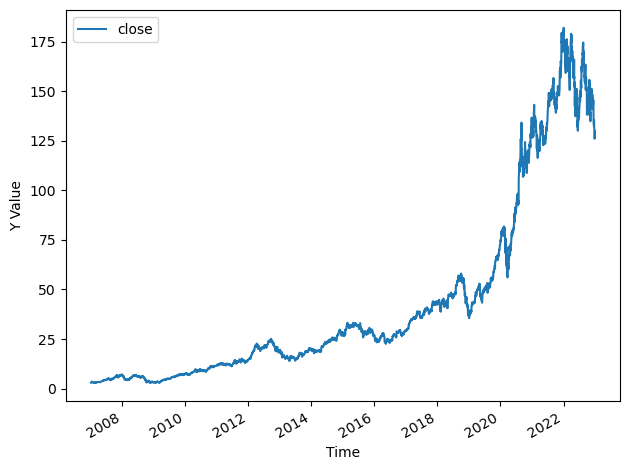

In [5]:
fig, ax = plt.subplots()

ax.plot(merged_df_timesnet['ds'], merged_df_timesnet['y'], label='close')

ax.set_xlabel('Time')
ax.set_ylabel('Y Value')

# Add legend to distinguish between different values
ax.legend()

# Rotate and align x-axis labels
fig.autofmt_xdate()

# Adjust layout to prevent overlapping labels
plt.tight_layout()

# Show the plot
plt.show()

In [6]:
trn_env = merged_df_timesnet[(merged_df_timesnet['ds'] >= trn_dt_range[0]) & (merged_df_timesnet['ds'] <= trn_dt_range[1])]
display(trn_env.shape)
tst_env = merged_df_timesnet[(merged_df_timesnet['ds'] >= tst_dt_range[0]) & (merged_df_timesnet['ds'] <= tst_dt_range[1])]
display(tst_env.shape)

(250, 6)

(41, 6)

In [7]:
timesnet_config= {
    "input_size": 100,      # Length of input window
    "hidden_size": 256,     # Size of embedding for embedding and encoders,
    "encoder_layers": 3,                    # num of encoders
    "learning_rate": 0.0008,            # Initial Learning rate
    "batch_size": 5,                                          # Number of series in batch
    'dropout': 0.1,                                           # Dropout for embeddings
    'conv_hidden_size' : 5,                                   # Channels for the inception block
    'top_k' : 5,                                              # Top num of periods from FFT considered
    'num_kernels' : 13,                 # Number of Filters
    'max_steps' : 100,                 # Number of Training Steps
    'early_stop_patience_steps' : 10,  # early stoppage on validation
    'val_check_steps' : 5,             # Val check every X steps,
    'windows_batch_size' : 60,         # Number of windows in training epoch
    'valid_batch_size' : 60
}


model = TimesNet(h = tst_env.shape[0], # Forecast horizon
                 input_size = 10, # Length of input window (lags)
                 batch_size = 1, 
                 futr_exog_list = remaining_columns,
                 hidden_size = 64, # Size of embedding for embedding and encoders,
                 dropout = 0.1, # Dropout for embeddings
                 conv_hidden_size = 1, # Channels for the inception block
                 top_k = 5, # Top num of periods from FFT considered
                 num_kernels = 13, # number of kernels for the inception block
                 encoder_layers = 3, # num of encoders
                 max_steps = 100, # of training steps
                 early_stop_patience_steps = -1, #early stoppage on validation
                 val_check_steps = 5, # Val check every X steps,
                 windows_batch_size = 64, # Number of windows in training epoch,
                 learning_rate = 0.0008)

c:\Users\beckm\anaconda3\envs\MADDQN\Lib\site-packages\pytorch_lightning\utilities\parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
Seed set to 1


In [8]:
nf = NeuralForecast(models=[model], freq='d')
nf.fit(df=trn_env)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type          | Params
-------------------------------------------------
0 | loss           | MAE           | 0     
1 | padder_train   | ConstantPad1d | 0     
2 | scaler         | TemporalNorm  | 0     
3 | model          | ModuleList    | 1.1 M 
4 | enc_embedding  | DataEmbedding | 384   
5 | layer_norm     | LayerNorm     | 128   
6 | predict_linear | Linear        | 561   
7 | projection     | Linear        | 65    
-------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.507     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\beckm\anaconda3\envs\MADDQN\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\beckm\anaconda3\envs\MADDQN\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\beckm\anaconda3\envs\MADDQN\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\beckm\anaconda3\envs\MADDQN\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
test_df = pd.DataFrame(tst_env])
forecast = nf.predict(df=test_df)

In [ ]:
print(forecast)
fig, ax = plt.subplots()

ax.plot(merged_df_timesnet['ds'], merged_df_timesnet['close']['y'], label='actual')
ax.plot(forecast['ds'],forecast['TimesNet'], label='TimesNet')


ax.legend(loc='best')


fig.autofmt_xdate()
plt.tight_layout()